🚀 Running Classical ML Benchmark (Fix)...

--- LABEL AUDIT ---
Total Rows: 283
Events (Surgery=1): 124 (43.8%)
Time Stats:
count     283.000000
mean     3033.780919
std      1016.700438
min       812.000000
25%      2485.500000
50%      3056.000000
75%      3343.000000
max      5838.000000
Name: time_to_event, dtype: float64

🌲 Training Forest on 198 samples (86 events)...

🏆 Final C-Index: 0.5664
   Calculating Permutation Importance...


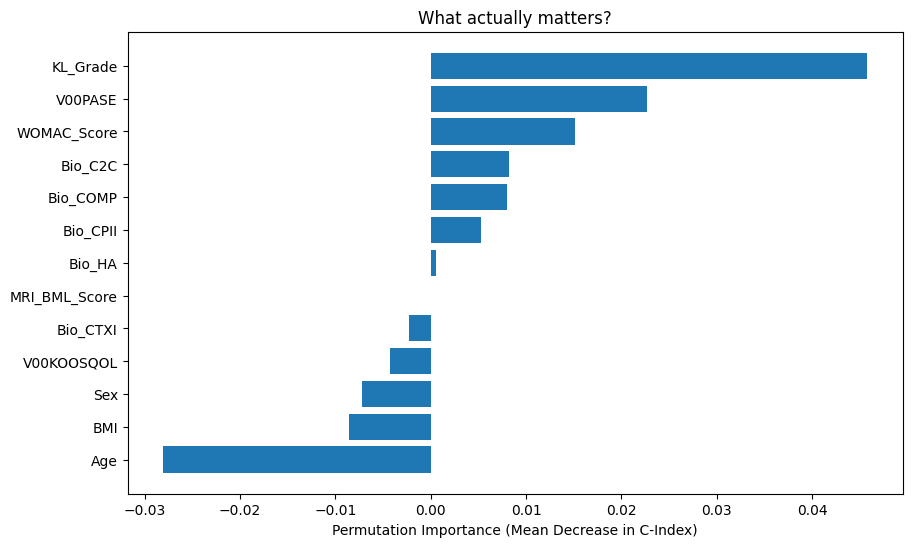

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance # <--- NEW IMPORT

# --- CONFIGURATION ---
PARQUET_PATH = '../data/processed/OAI_platinum_cohort.parquet'

print(f"🚀 Running Classical ML Benchmark (Fix)...")

# 1. Load Data
df = pd.read_parquet(PARQUET_PATH)

# --- 2. CRITICAL DATA AUDIT ---
# Before training, we MUST verify the labels.
print("\n--- LABEL AUDIT ---")
print(f"Total Rows: {len(df)}")
print(f"Events (Surgery=1): {df['event'].sum()} ({df['event'].mean():.1%})")
print(f"Time Stats:\n{df['time_to_event'].describe()}")

# Check for common bugs
if (df['time_to_event'] <= 0).any():
    print("⚠️ WARNING: Found 0 or Negative times! Dropping them...")
    df = df[df['time_to_event'] > 0]

if df['event'].sum() < 10:
    print("🚨 CRITICAL: Not enough events to train! (<10)")
# -----------------------------

# 3. Prepare Features
features = [
    'Age', 'BMI', 'Sex', 'KL_Grade', 'WOMAC_Score', 
    'V00KOOSQOL', 'V00PASE',            # Clinical
    'MRI_BML_Score',                    # MRI (No Cyst)
    'Bio_COMP', 'Bio_CTXI', 'Bio_HA', 'Bio_C2C', 'Bio_CPII' # Biomarkers
]

# Standardize Sex
if df['Sex'].dtype == 'O':
    df['Sex'] = df['Sex'].map({'Male': 0, 'Female': 1})

X = df[features].fillna(0)

# 4. Prepare Target
y = np.zeros(len(df), dtype=[('Status', '?'), ('Survival_in_days', '<f8')])
y['Status'] = df['event'].astype(bool)
y['Survival_in_days'] = df['time_to_event']

# 5. Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"\n🌲 Training Forest on {len(X_train)} samples ({y_train['Status'].sum()} events)...")
rsf = RandomSurvivalForest(n_estimators=1000, min_samples_leaf=10, n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)

# 6. Evaluate
c_index = rsf.score(X_test, y_test)
print(f"\n🏆 Final C-Index: {c_index:.4f}")

# 7. Feature Importance (Permutation Method)
print("   Calculating Permutation Importance...")
result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# Plot
perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(result.importances_mean)

plt.figure(figsize=(10, 6))
plt.barh(range(len(features)), result.importances_mean[perm_sorted_idx], align='center')
plt.yticks(range(len(features)), [features[i] for i in perm_sorted_idx])
plt.xlabel("Permutation Importance (Mean Decrease in C-Index)")
plt.title("What actually matters?")
plt.show()